In [3]:
## if train
# !python train.py --mode='train' --model_dir='../model_dir/' --config_file="./configs/config_wl.yaml" --num_gpus=1

In [11]:
import sys
sys.path.append("./deeplab/")

import yaml

from config_yml import ExperimentOptions
from trainer.train import DeepCellModule

%load_ext autoreload
%autoreload 2

2023-02-12 01:35:15.970025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
mode = 'test'
model_dir = "/home/wli6/project/deepyeast_model_001/model_001"
num_gpus=0
with open("./deeplab/configs/config_wl.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
configs = ExperimentOptions(config)
# configs.model_options.backbone.drop_path_keep_prob=1

In [13]:
cellmodel = DeepCellModule(mode, configs, num_gpus, model_dir=model_dir)

2023-02-12 01:35:21.727654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: /home/wli6/project/deepyeast_model_001/tf/val*.tfrecord'

In [15]:
import tensorflow as tf
cellmodel = tf.saved_model.load("/Users/wlli/project/model_deepyeast_001/save2/")

In [11]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

In [13]:
img = imread("/home/wli6/Desktop/3306_REF_DIC_01_00.png")

In [14]:
output = cellmodel.predict(img)

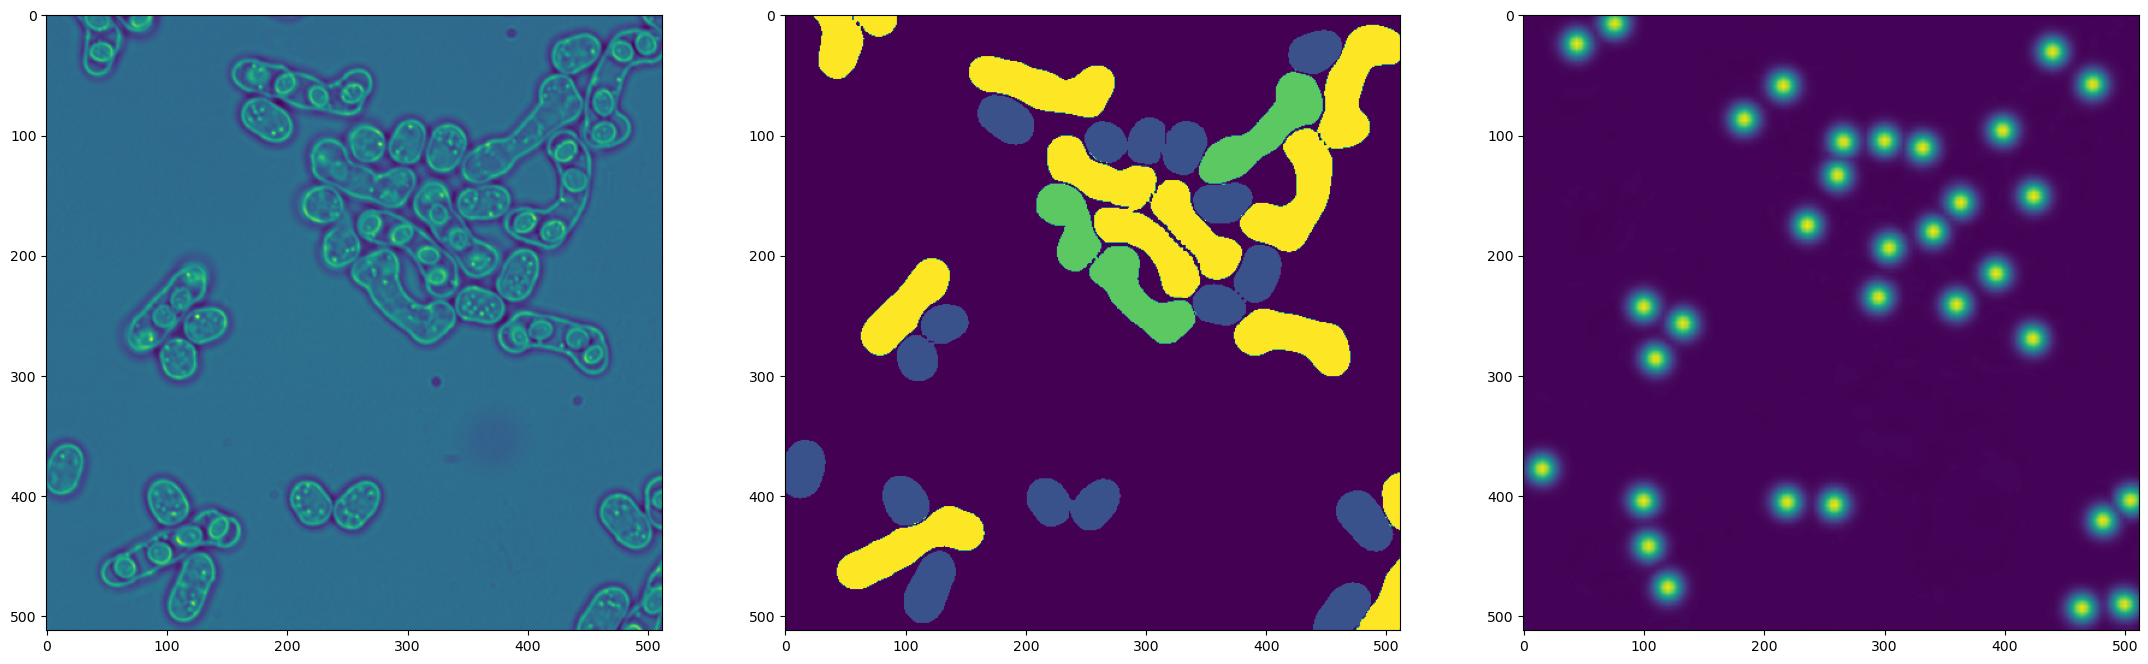

In [15]:
figs, axs = plt.subplots(1,3, figsize=(27,9))
axs[0].imshow(img)
axs[1].imshow(output['panoptic_pred'][0])
axs[2].imshow(output['center_heatmap'][0])

In [ ]:
post_process_panoptic()

In [2]:
num_gpus=1
global_step = orbit.utils.create_global_step()
strategy = distribution_utils.create_strategy(num_gpus)
model_dir = "../model_dir/"


with open("./configs/config_wl.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
configs = ExperimentOptions(config)

dataset_name = configs.eval_dataset_options.dataset
datasets = dataset.MAP_NAME_TO_DATASET_INFO[dataset_name]

2022-12-28 17:43:52.895504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-28 17:43:53.438296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38224 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


In [24]:
# dataset_name = configs.eval_dataset_options.dataset
# datasets = dataset.MAP_NAME_TO_DATASET_INFO[dataset_name]
with strategy.scope():
    model = DeepLab(configs, datasets)
    losses = DeepLabFamilyLoss(
                loss_options=configs.trainer_options.loss_options,
                num_classes=datasets.num_classes,
                ignore_label=datasets.ignore_label,
                ignore_depth=datasets.ignore_depth,
                thing_class_ids=datasets.class_has_instances_list)
    trainer = None #trainer_lib.Trainer(configs, model, losses, global_step)
    evaluator = evaluator_lib.Evaluator(configs, model, losses,
                                            global_step, model_dir)

checkpoint_dict = dict(global_step=global_step)
checkpoint_dict.update(model.checkpoint_items)
if trainer is not None:
    checkpoint_dict['optimizer'] = trainer.optimizer
    if trainer.backbone_optimizer is not None:
        checkpoint_dict['backbone_optimizer'] = trainer.backbone_optimizer
checkpoint = tf.train.Checkpoint(**checkpoint_dict)

init_dict = model.checkpoint_items
init_fn = functools.partial(runner_utils.maybe_load_checkpoint,
                        configs.model_options.initial_checkpoint,
                        init_dict)

checkpoint_manager = tf.train.CheckpointManager(
    checkpoint,
    directory=model_dir,
    max_to_keep=1,#configs.trainer_options.num_checkpoints_to_keep,
    step_counter=global_step,
    checkpoint_interval=configs.trainer_options.save_checkpoints_steps,
    init_fn=init_fn
)

controller = orbit.Controller(
    strategy=strategy,
    trainer=trainer,
    evaluator=evaluator,
    global_step=global_step,
    steps_per_loop=configs.trainer_options.steps_per_loop,
    checkpoint_manager=checkpoint_manager,
    summary_interval=configs.trainer_options.save_summaries_steps,
    summary_dir=os.path.join(model_dir, 'train'),
    eval_summary_dir=os.path.join(model_dir, 'eval')
)

DEEPLAB INIT
DEEPLAB INIT (33, 33)
Setting pooling size to %s (33, 33)
restoring or initializing model...
restored model from ../model_dir/ckpt-60000.
restored from checkpoint: ../model_dir/ckpt-60000


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [25]:
# controller.evaluate(steps=-1)

In [4]:
with open("./configs/config_wl.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
configs = ExperimentOptions(config)

dataset_name = configs.eval_dataset_options.dataset
datasets = dataset.MAP_NAME_TO_DATASET_INFO[dataset_name]

deeplab = DeepLab(configs, datasets)
deeplab.load_weights("../model_dir/ckpt-60000.index")
# checkpoint_dict = dict(global_step=global_step)
# checkpoint_dict.update(deeplab.checkpoint_items)
# checkpoint = tf.train.Checkpoint(**checkpoint_dict)

# init_dict = model.checkpoint_items
# init_fn = functools.partial(runner_utils.maybe_load_checkpoint,
#                         configs.model_options.initial_checkpoint,
#                         init_dict)

# checkpoint_manager = tf.train.CheckpointManager(
#     checkpoint,
#     directory=model_dir,
#     max_to_keep=1,#configs.trainer_options.num_checkpoints_to_keep,
#     step_counter=global_step,
#     checkpoint_interval=configs.trainer_options.save_checkpoints_steps,
#     init_fn=init_fn
# )

DEEPLAB INIT
DEEPLAB INIT (33, 33)
Setting pooling size to %s (33, 33)
Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [ ]:
deeplab.checkpoint_items

In [5]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from keras.backend import manual_variable_initialization
manual_variable_initialization(True)

In [6]:
with tf.io.gfile.GFile("../../data/set6/images/val/val/IBC180_004.png", 'rb') as f:
    image_data = f.read()
img = imread(image_data, plugin='imageio')
img = img.astype(np.uint16)

# img = (img-np.min(img)) / (np.max(img)-np.min(img))
a = tf.cast(img.reshape(1,img.shape[0], img.shape[1],1), dtype=tf.float32)
output = deeplab.predict(a)

norm
Getting pooling size to %s (None, None)
Eval with scales %s ListWrapper([1.0]) (None, None)
norm
Getting pooling size to %s (None, None)
Eval with scales %s ListWrapper([1.0]) (None, None)


2022-12-28 17:45:04.365449: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-28 17:45:11.228948: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-28 17:45:11.491196: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 33s 33s/step


In [34]:
model.save("tes1")

norm
Getting pooling size to %s (None, None)
Eval with scales %s ListWrapper([1.0]) (None, None)


norm
Getting pooling size to %s (None, None)
Eval with scales %s ListWrapper([1.0]) (None, None)
norm
norm
Getting pooling size to %s (None, None)
Eval with scales %s ListWrapper([1.0]) (None, None)
norm
norm
Getting pooling size to %s (None, None)
Eval with scales %s ListWrapper([1.0]) (None, None)
norm


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Assets written to: tes1/assets


INFO:tensorflow:Assets written to: tes1/assets


In [37]:
from keras.models import load_model
loaded_dp = load_model("./tes1")

In [1]:
with tf.io.gfile.GFile("../../data/set6/images/val/val/IBC180_004.png", 'rb') as f:
    image_data = f.read()
img = imread(image_data, plugin='imageio')
img = img.astype(np.uint16)

# img = (img-np.min(img)) / (np.max(img)-np.min(img))
a = tf.cast(img.reshape(1,img.shape[0], img.shape[1],1), dtype=tf.float32)
output = loaded_dp.predict(a)

NameError: name 'tf' is not defined

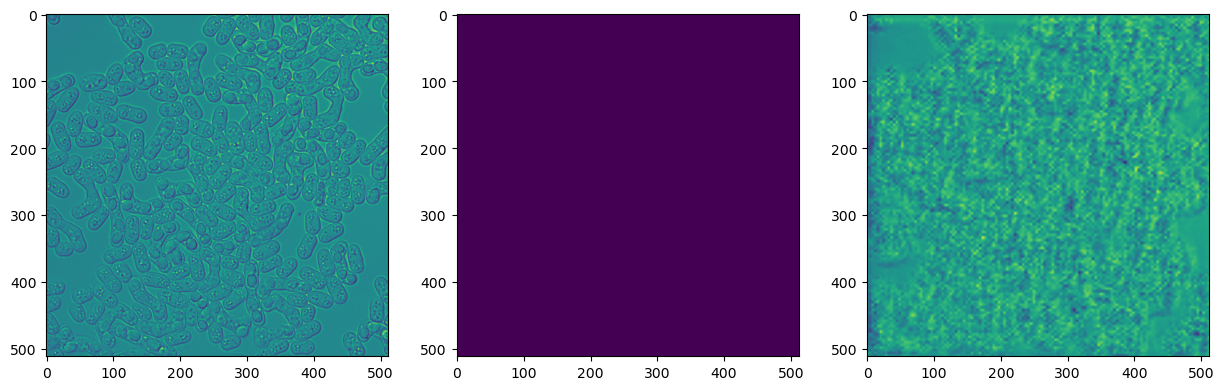

In [8]:
figs, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(a[0,:,:,0])
axs[1].imshow(output['panoptic_pred'][0])
axs[2].imshow(output['center_heatmap'][0])

In [37]:
import sys
sys.path.append(".")
# sys.path.append("./model/encoder/")


import yaml

from config_yml import ExperimentOptions
from model.encoder.axial_resnet_instances import AxialSWideRNet
from model.decoder.panoptic_deeplab import PanopticDeepLab
from model.builder import create_encoder
import tensorflow as tf
import numpy as np
from model.post_processor.post_processor_builder import get_post_processor
from data import dataset
#from deeplab import DeepLab
from model.loss.loss_builder import DeepLabFamilyLoss
import orbit

from trainer import trainer as trainer_lib
from trainer import evaluator as evaluator_lib
from trainer import runner_utils

from data.build_cell_data import _convert_dataset
from data.preprocessing import autoaugment_policy
from data import data_utils
from data import data_utils_test

import matplotlib.pyplot as plt

from skimage.io import imsave
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from skimage.io import imread
import common
from skimage.color import label2rgb
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
a = data_utils_test.DataUtilsTest()
c,d = a.test_encode_and_decode_panoptic()

max: 9993


In [39]:
with open("./configs/config_wl.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
configs = ExperimentOptions(config)

In [46]:
_convert_dataset("../../data/set7/","train", ".././tf/train/", True)

../../data/set7/images/train/1_100_2x2/3306_REF_DIC_01_00.png
4032
max: 18637
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_02_03.png
4053
max: 18644
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_03_01.png
4040
max: 18927
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_04_04.png
4050
max: 18343
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_05_05.png
4029
max: 16815
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_06_01.png
4041
max: 18449
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_07_07.png
4041
max: 18315
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_08_05.png
4032
max: 15982
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_09_01.png
4031
max: 18389
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_10_04.png
4051
max: 17442
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_11_04.png
4066
max: 18152
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_12_06.png
4049
max: 16011
../../data/set7/images/train/1_100_2x2/3306_REF_DIC_13_01.png
40

In [47]:
autoaugment_policy.convert_policy(autoaugment_policy.simple_classification_policy)

[[('Sharpness', 0.4, 7), ('Brightness', 0.2, 10)],
 [('Equalize', 0.0, 9), ('Contrast', 0.2, 10)],
 [('Sharpness', 0.2, 9), ('Invert', 0.2, 9)],
 [('Solarize', 0.2, 7), ('Equalize', 0.6, 9)],
 [('Sharpness', 0.2, 1), ('Equalize', 0.2, 7)]]

In [48]:
celldataset = runner_utils.create_dataset(configs.train_dataset_options,
    is_training=True,                      
    only_semantic_annotations=False)

get randowm scale: Tensor("strided_slice:0", shape=(), dtype=float32)
00000 (None, None, 1)
1111 (None, None, 1)
2222 (513, 513, 1)
33333 (513, 513, 1)


In [49]:
for example in tfds.as_numpy(celldataset.take(1)):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    gt = example["panoptic_gt"]
    ct = example["instance_center_gt"]
  # label = example["label"]
    print(image.shape,image.max(),image.min(), gt.dtype)

['image', 'semantic_gt', 'semantic_loss_weight', 'is_crowd_gt', 'panoptic_gt', 'center_loss_weight', 'regression_loss_weight', 'instance_center_gt', 'instance_regression_gt']
(32, 513, 513, 1) 65535.0 0.0 int32


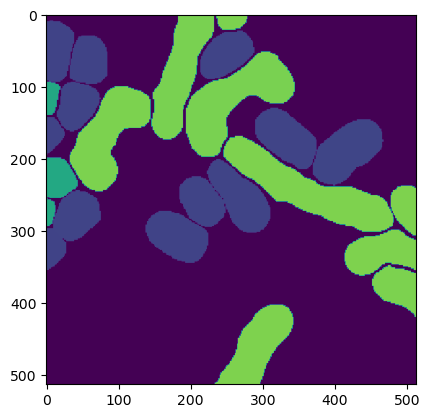

In [50]:
plt.imshow(gt[0,:,:],vmax=5000)

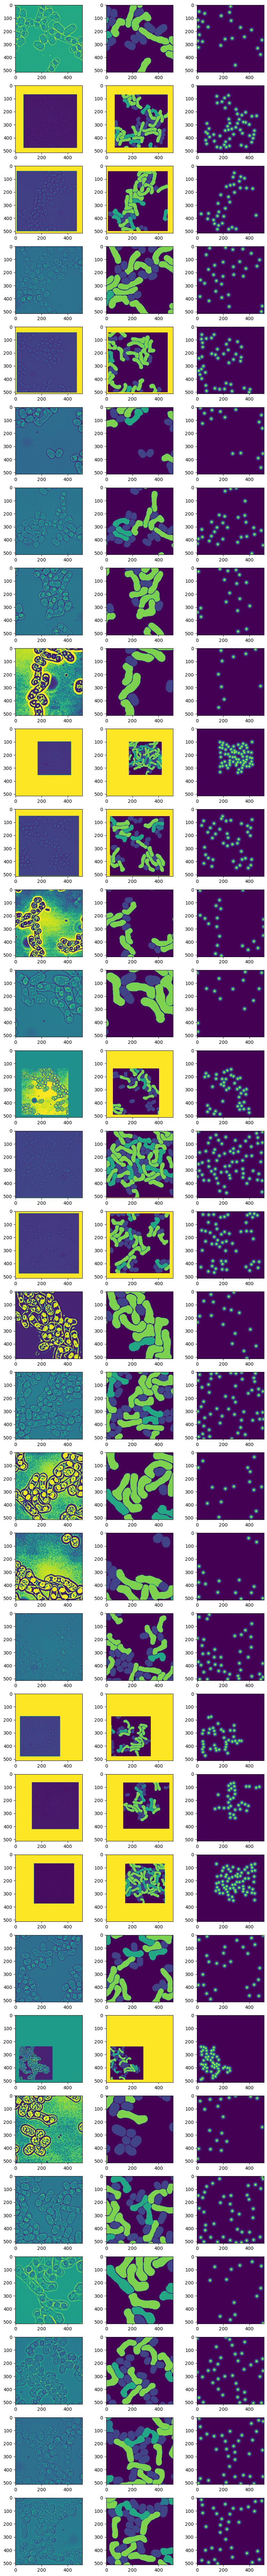

In [51]:
fig,axs = plt.subplots(32, 3, figsize=(10, 100))
for i in range(0,32):
    axs[i,0].imshow(image[i,:,:,0])
    axs[i,1].imshow(gt[i,:,:],vmax=5000)
    axs[i,2].imshow(ct[i,:,:])
    # print(image[i,:,:,0].max(),image[i,:,:,0].min())

In [75]:
testdataset = runner_utils.create_dataset(configs.eval_dataset_options,
    is_training=True,                      
    only_semantic_annotations=False)

00000 (None, None, 1)
1111 (None, None, 1)
2222 (513, 513, 1)
33333 (513, 513, 1)


In [ ]:
for example in tfds.as_numpy(testdataset.take(1)):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    #gt = example["panoptic_gt"]
    #ct = example["instance_center_gt"]
  # label = example["label"]
    print(image.shape,image.max(),image.min())

In [318]:
img = image[1,:,:,0:1]
scale = 0.3
image_shape = tf.shape(img)
new_dim = tf.cast(
  tf.cast([image_shape[0], image_shape[1]], tf.float32) * scale,
  tf.int32)

# Need squeeze and expand_dims because image interpolation takes
# 4D tensors as input.
img = tf.squeeze(
  tf.compat.v1.image.resize_bilinear(
      tf.expand_dims(img, 0), new_dim, align_corners=True), [0])

In [343]:
dataset = tf.data.Dataset.list_files(
    configs.train_dataset_options.file_pattern, shuffle=False)
dataset = dataset.take(1)
dataset = dataset.interleave(
    map_func=tf.data.TFRecordDataset,
    cycle_length=(_NUM_INPUTS_PROCESSED_CONCURRENTLY
                  if False else 1),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
    deterministic=not False)

In [259]:
im = image[0,:,:,:]
c = 0
im = tf.cast(im[:, :, c]*65535, tf.int32)
# Compute the histogram of the image channel.
histo = tf.histogram_fixed_width(im, [0, 65535], nbins=65536)

# For the purposes of computing the step, filter out the nonzeros.
nonzero = tf.where(tf.not_equal(histo, 0))
nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 65535

def build_lut(histo, step):
  # Compute the cumulative sum, shifting by step // 2
  # and then normalization by step.
    lut = (tf.cumsum(histo) + (step // 2)) // step
  # Shift lut, prepending with 0.
    lut = tf.concat([[0], lut[:-1]], 0)
  # Clip the counts to be in range.  This is done
  # in the C code for image.point.
    return tf.clip_by_value(lut, 0, 65535)

# If step is zero, return the original image.  Otherwise, build
# lut from the full histogram and step and then index from it.
result = tf.cond(tf.equal(step, 0),
                 lambda: im,
                 lambda: tf.gather(build_lut(histo, step), im))
result = result/65535

In [128]:
decoder = data_utils.SegmentationDecoder(
  is_panoptic_dataset=True,
  decode_groundtruth_label=configs.train_dataset_options.decode_groundtruth_label)
reader = InputReader(
  file_pattern=configs.train_dataset_options.file_pattern,
  decoder_fn=decoder,
  generator_fn=None,
  is_training=True,)

In [129]:
reader = reader(configs.train_dataset_options.batch_size)

In [131]:
for example in tfds.as_numpy(reader.take(10)):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    # print(list(example.keys()))
    image = example["image"]
    #gt = example["panoptic_gt"]
    #ct = example["instance_center_gt"]
  # label = example["label"]
    print(image.shape, np.max(image))#.max(),image.min(), gt.shape)

(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30275425
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30275425
(32, 512, 512, 1) 0.30280003
(32, 512, 512, 1) 0.30275425
(32, 512, 512, 1) 0.30275425


### sj

In [145]:
from skimage.io import imsave, imread
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns

In [241]:
from analyser.mask_feature import MaskFeature
from postprocess.post_process_utils import post_process_panoptic, post_process_single_cell_region
from skimage.segmentation import expand_labels
from skimage.morphology import erosion, dilation, disk
from analyser.cell_image import CellImage
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
image = imread("../data_test/20220707_yGL0360xyGL0105_06_snapshot_R3D.tif")
# image = np.moveaxis(image, -1, 0)
# image[:,:,:] = image[:,:,:]

In [219]:
image[:,:,0].shape

(2040, 2040)

In [222]:
output = cellmodel.predict(image[:,:,0])
# output = cellmodel(tf.cast(image[0].reshape(image[0].shape[0], image[0].shape[1], 1), dtype=tf.float16))
# imsave("../../output/mask.tif",imread_collection_wrapperput['panoptic_pred'][0].numpy())

In [223]:
pmask = post_process_panoptic(output["panoptic_pred"][0].numpy(), area_threshold=1000)

In [234]:
# plt.imshow(pmask)

In [34]:
imsave("./testmask.tif", pmask)

In [224]:
mf = MaskFeature(pmask)

In [226]:
mf.instance_properties

label   centroid_0   centroid_1  orientation  axis_major_length  \
0     1001    34.173532   170.158287    -0.025136          71.515350   
1     1002     9.798707   360.222530     1.562330          56.630586   
2     1003    15.810811   421.063784     1.530321          61.494657   
3     1004    11.465413   644.122901     1.535659          67.650800   
4     1005    17.689600   968.196800    -1.479278          95.607060   
..     ...          ...          ...          ...                ...   
365   5018  1734.192428  1460.053864     0.065171          86.632291   
366   5019  1750.239778  1373.942027     1.346101         114.991904   
367   5020  1935.599307   410.169828    -1.009092         206.236738   
368   5021  1902.344871   672.449339     0.196964          57.924046   
369   5022  2013.757796   375.511175    -1.212932         135.345624   

     axis_minor_length   area  bbox_0  bbox_1  bbox_2  bbox_3  eccentricity  \
0            55.506712   3083       0     139      70     198      0.630547   
1            27.015293   1083       0     329      26     390      0.878879   
2            41.095442   1850       0     389      38     453      0.743913   
3            30.297610   1489       0     608      30     679      0.894107   
4            44.498527   3125       0     926      44    1019      0.885084   
..                 ...    ...     ...     ...     ...     ...           ...   
365          75.958407   5124    1691    1424    1775    1500      0.480872   
366          77.081205   6848    1714    1315    1793    1428      0.742073   
367          70.687331  10387    1870     329    2002     496      0.939427   
368          35.750252   1589    1874     656    1932     691      0.786813   
369          45.728087   3848    1974     313    2040     437      0.941196   

                                   coords  semantic  instance  \
0            [[0.0, 181.5], [6.0, 186.5]]         1         1   
1            [[0.0, 389.5], [4.0, 388.5]]         1         2   
2            [[0.0, 452.5], [6.0, 451.5]]         1         3   
3            [[0.0, 675.5], [4.0, 677.5]]         1         4   
4          [[0.0, 1018.5], [8.0, 1017.5]]         1         5   
..                                    ...       ...       ...   
365  [[1774.5, 1476.0], [1774.5, 1460.0]]         5        18   
366  [[1792.5, 1360.0], [1781.5, 1351.0]]         5        19   
367    [[2001.5, 362.0], [1992.0, 340.5]]         5        20   
368    [[1931.5, 672.0], [1929.5, 665.0]]         5        21   
369    [[2013.5, 427.0], [2012.5, 421.0]]         5        22   

     is_out_of_border  
0                True  
1                True  
2                True  
3                True  
4                True  
..                ...  
365             False  
366             False  
367             False  
368             False  
369              True  

[370 rows x 16 columns]

In [166]:
%%time
data = mf.instance_properties()

CPU times: user 16.8 s, sys: 0 ns, total: 16.8 s
Wall time: 16.8 s


In [37]:
# cost = mf.all_by_all_distance()

In [242]:
fi = CellImage(image, pmask)

In [243]:
f_ins = fi.get_fluorescent_intensity()

In [246]:
cluster = FluorescentClassification(f_ins)

In [247]:
cluster

In [249]:
data_pred, clustering = cluster.predition_data_type(n_components=4, init_params='kmeans')

/home/wli6/miniconda3/envs/deepyeast/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [250]:
cluster.data

label     ch1    ch2          bg1         bg2  ch1_norm  ch2_norm  \
1001   1001  6243.8  220.0  1452.958831  251.604396  1.200236  0.975717   
1002   1002  1005.0  224.0  1452.958831  251.604396  0.949376  0.978977   
1003   1003  1105.1  287.1  1452.958831  251.604396  0.962415  1.023874   
1004   1004  6924.8  337.0  1452.958831  251.604396  1.214453  1.052864   
1005   1005  7081.2  266.0  1452.958831  251.604396  1.217520  1.010065   
...     ...     ...    ...          ...         ...       ...       ...   
5018   5018  1842.0  262.0  1452.958831  251.604396  1.032583  1.007324   
5019   5019  6131.6  269.0  1452.958831  251.604396  1.197745  1.012094   
5020   5020  1330.0  291.0  1452.958831  251.604396  0.987856  1.026315   
5021   5021  1174.0  254.0  1452.958831  251.604396  0.970722  1.001714   
5022   5022  7741.6  251.0  1452.958831  251.604396  1.229766  0.999565   

      channel_prediction  
1001                   1  
1002                   0  
1003                   0  
1004                   1  
1005                   1  
...                  ...  
5018                   0  
5019                   1  
5020                   0  
5021                   0  
5022                   1  

[370 rows x 8 columns]

In [251]:
showdata = cluster.data.copy()
showdata[["centroid_0","centroid_1"]] = fi.mask.instance_properties.iloc[:,[1,2]]

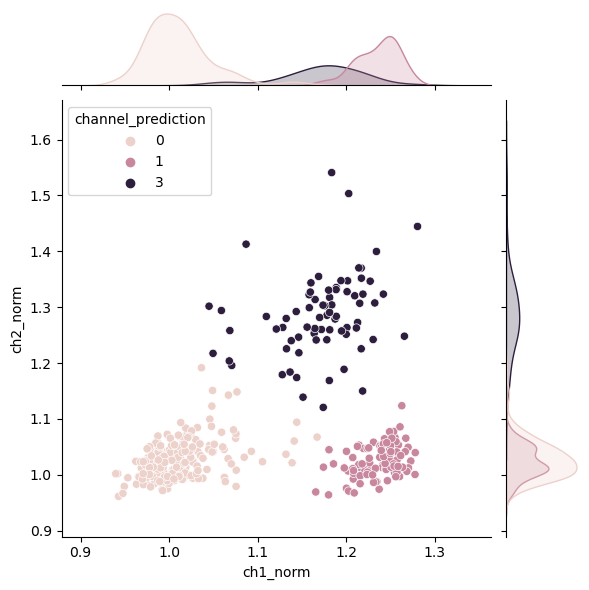

In [252]:
sns.jointplot(data=showdata, x="ch1_norm", y="ch2_norm",  hue='channel_prediction')

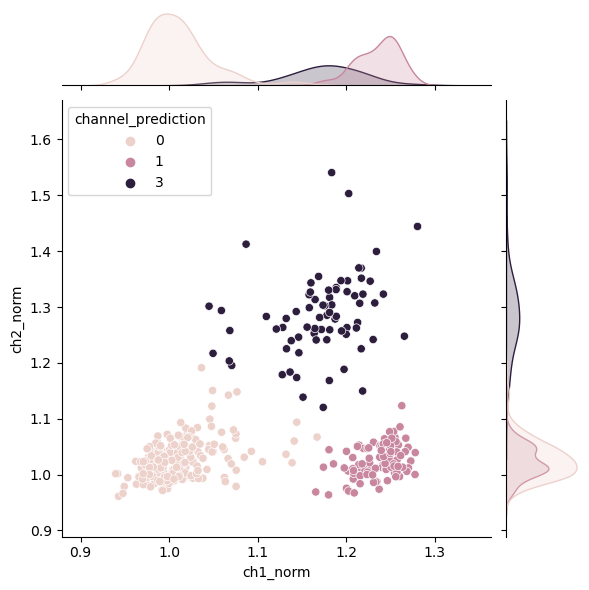

In [65]:
sns.jointplot(data=cluster.data, x="ch1_norm", y="ch2_norm",  hue='channel_prediction')

In [255]:
def plot_figures(cf, exp_data, num, is_show=True, save_dir="", basename="", sub_figsize=5):
    """Plot calculation result
    """
    f = sns.jointplot(data=exp_data, x="ch1_norm", y="ch2_norm",  hue='channel_prediction')
    f.savefig('tmp1.png')
    plt.close(f.fig)
    f = sns.jointplot(data=exp_data, x="ch1_norm", y="ch2_norm",  hue='channel_prediction')
    f.savefig('tmp2.png')
    plt.close(f.fig)
    fig, axs = plt.subplots(2, num, figsize=(sub_figsize*num, sub_figsize*2))
    # plot images
    for i in range(0, cf.image.shape[0]):
        axs[0, i].imshow(cf.image[:,:,i], cmap="gray")
        if i == 0:
            show_data = exp_data.loc[exp_data.channel_prediction == 0]
            color = 'w'
        elif i == 1:
            show_data = exp_data.loc[(exp_data.channel_prediction == 1) | (exp_data.channel_prediction == 3)]
            color = 'r'
        elif i == 2:
            show_data = exp_data.loc[exp_data.channel_prediction == 2]
            color = 'g'
        # elif i > 2:
        #     show_data = exp_data.loc[exp_data.channel_prediction > 2]
        #     color = 'b'
        axs[0, i].scatter(show_data['centroid_1'], show_data['centroid_0'],c=color,marker='.')
        axs[0, 0].scatter(show_data['centroid_1'], show_data['centroid_0'],c=color,marker='.')

    # plot images
    for i in range(0, cf.image.shape[0]):
        axs[1, i].imshow(cf.image[i], cmap="gray")
        if i == 0:
            show_data = exp_data.loc[exp_data.channel_prediction == 0]
            color = 'w'
        elif i == 1:
            show_data = exp_data.loc[(exp_data.channel_prediction == 1) | (exp_data.channel_prediction == 3)]
            color = 'r'
        elif i == 2:
            show_data = exp_data.loc[exp_data.channel_prediction == 2]
            color = 'g'
        # elif i > 2:
        #     show_data = exp_data.loc[exp_data.channel_prediction_2 > 2]
        # color = 'b'
        axs[1, i].scatter(show_data['centroid_1'], show_data['centroid_0'],c=color,marker='.')
        axs[1, 0].scatter(show_data['centroid_1'], show_data['centroid_0'],c=color,marker='.')

    axs[0, 3].imshow(imread('tmp1.png'))
    
        
    # plot statistics
    axs[1, 3].imshow(imread('tmp2.png'))
    fig.suptitle(basename)
    # close axis
    for i in range(0, 2):
        for j in range(0, num):
            axs[i, j].axis("off")
    # set layout
    plt.tight_layout()
    if not is_show:
        plt.close(fig)


In [260]:
# plot_figures(fi, showdata, 4)

In [257]:
# movies

In [269]:
from tqdm import trange

In [295]:
# from analyser.celltracing import CellTracer
from analyser.tracer import Tracer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [273]:
movie = imread("../data_test/YAV2104xYAV2105_005_13_R3D.dv.tif")

In [276]:
mask = np.zeros(movie.shape[0:3])
for i in trange(0, movie.shape[0]):
    p = cellmodel.predict(movie[i,:,:,0])
    p = post_process_panoptic(p["panoptic_pred"][0].numpy(), area_threshold=1000)
    mask[i] = p

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [15:14<00:00, 18.29s/it]


In [278]:
imsave("../data_test/mask_YAV2104xYAV2105_005_13_R3D.tif", mask)

In [296]:
ter = Tracer(mask)

NameError: name '_Tracer__frame_name' is not defined